### **LSTM(Long-Short Term Memory)**

RNN의 장기의존성 문제를 해결하기 위해 고안된 모델로 

Cell State와 Gate라는 개념이 추가되어 장기기억, 단기기억을 모두 가져갈수있게 됨


### **LSTM Architecture**
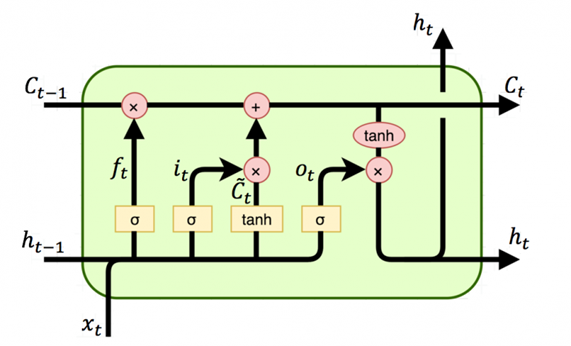

### **Forgot Gate**
- 이전 정보를 잊기 위한 게이트, Cell State로 부터 어느 정도의 정보를 버릴 것인지 결정 

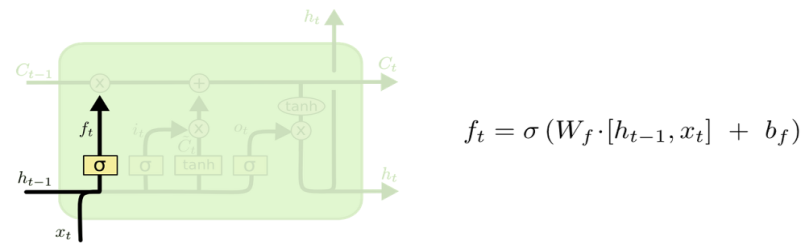

### **Input Gate, Cell Candidate**
- 새로 들어오는 정보 중 input gate를 통해 어느 정도의 정보를 Cell State에 수용할건지 결정 
- 새롭게 업데이트 할 후보 Cell State 결정 
- $i_t$ => input_gate, $\hat{C}_t$ => Cell 후보군 
- 두개가 곱해져 새롭게 들어갈 셀 후보군이 정해짐

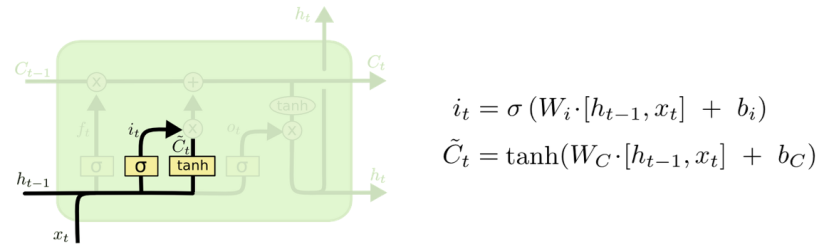

### **Cell State**

- 이전 Cell State ($C_{t-1}$)를 얼만큼 잊을 것인지에 대한 정보 (Forgot Gate)
- 새롭게 업데이트할 후보 Cell State를 얼만큼 수용할 것인지에 대한 정보 (Input Gate)를 활용하여 해당 시점의 새로운 Cell State를 업데이트

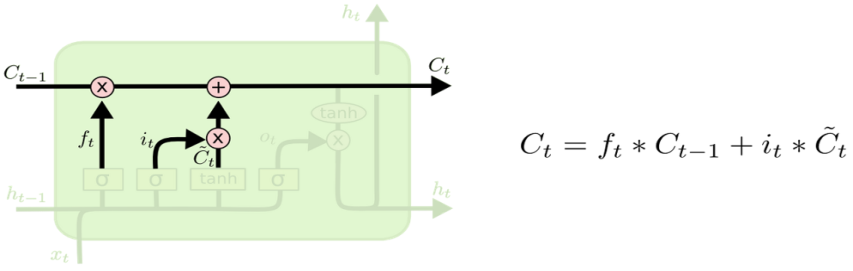

### **Output Gate**
- 새롭게 업데이트된 Cell State중 어느 정보를 최종적으로 출력할건지 결정 

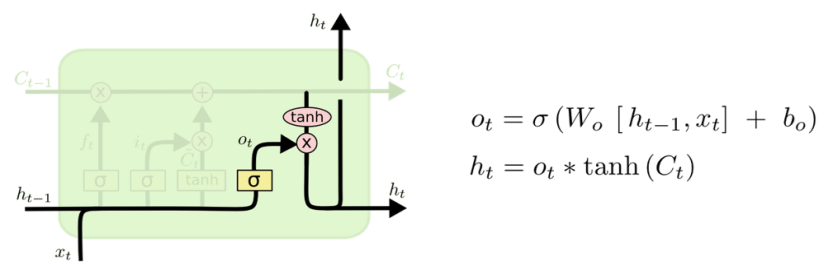

### **LSTM Cell**

In [ ]:
import torch
import torch.nn as nn

# 모든 가중치 분리 
class lstm1(nn.Module):
    def __init__(self, in_dim, hi_dim):
        super().__init__()
        
        self.hi_dim = hi_dim
        
        # 은닉 상태 가중치 
        self.whf = nn.Linear(hi_dim, hi_dim)
        self.whi = nn.Linear(hi_dim, hi_dim)
        self.whg = nn.Linear(hi_dim, hi_dim)
        self.who = nn.Linear(hi_dim, hi_dim)
        
        # 게이트 가중치
        self.wf = nn.Linear(in_dim, hi_dim)
        self.wi = nn.Linear(in_dim, hi_dim)
        self.wg = nn.Linear(in_dim, hi_dim)
        self.wo = nn.Linear(in_dim, hi_dim)
        
        
    def forward(self, x, ht_1, ct_1):
        
        # forgot gate
        f_t = torch.sigmoid(self.wf(x) + self.whf(ht_1))
        
        # input gate
        i_t = torch.sigmoid(self.wi(x) + self.whi(ht_1))
        
        # candidate 
        g_t = torch.tanh(self.wg(x) + self.whg(ht_1))
        
        # output gate
        o_t = torch.sigmoid(self.wo(x) + self.who(ht_1))
        
        # cell state
        c_t = f_t * ct_1 + i_t * g_t
        
        # hidden state
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t
        
# 입력 + 은닉 가중치
class lstm2(nn.Module):
    def __init__(self, in_dim, hi_dim):
        super().__init__()
        
        self.hi_dim = hi_dim
        
        self.wf = nn.Linear(in_dim + hi_dim, hi_dim)    # forgot gate weight
        self.wi = nn.Linear(in_dim + hi_dim, hi_dim)    # input gate weight
        self.wg = nn.Linear(in_dim + hi_dim, hi_dim)    # candidate gate weight
        self.wo = nn.Linear(in_dim + hi_dim, hi_dim)    # output gate weight
        
    def forward(self, x, h0 = None, c0 = None):
        
        # 초기 히든 상태와 셀 상태 설정
        if h0 is None:
            h0 = torch.zeros(x.size(0), self.hi_dim, device=x.device)
            
        if c0 is None:
            c0 = torch.zeros(x.size(0), self.hi_dim, device=x.device)
            
        # 
        x_ht_1 = torch.cat([x, h0], dim = 1)
        
        # input gate
        f_t = torch.sigmoid(self.wf(x_ht_1))
        i_t = torch.sigmoid(self.wi(x_ht_1))
        g_t = torch.tanh(self.wg(x_ht_1))
        o_t = torch.sigmoid(self.wo(x_ht_1))
        
        c_t = f_t * c0 + i_t * g_t

        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t
        
# 입력 + 은닉 분해
class LSTM3(nn.Module):
    def __init__(self, in_dim, hi_dim):
        super().__init__()
        
        self.hi_dim = hi_dim
        
        # 하나의 선형 변환으로 모든 게이트 계산
        self.linear = nn.Linear(in_dim + hi_dim, hi_dim * 4)
        
    def forward(self, x, ht_1=None, ct_1=None):
        batch_size = x.size(0)
        
        # 초기 히든 상태와 셀 상태 설정
        if ht_1 is None:
            ht_1 = torch.zeros(batch_size, self.hi_dim, device=x.device)
        if ct_1 is None:
            ct_1 = torch.zeros(batch_size, self.hi_dim, device=x.device)
        
        # 입력과 이전 히든 상태 결합
        x_ht_1 = torch.cat([x, ht_1], dim=1)
        
        # 선형 변환 후 게이트 분리
        gates = self.linear(x_ht_1)
        f_t, i_t, g_t, o_t = torch.chunk(gates, 4, dim=1)
        
        # 활성화 함수 적용
        f_t = torch.sigmoid(f_t)  # forget gate
        i_t = torch.sigmoid(i_t)  # input gate
        g_t = torch.tanh(g_t)     # candidate
        o_t = torch.sigmoid(o_t)  # output gate
        
        # 새로운 셀 상태와 히든 상태 계산
        c_t = f_t * ct_1 + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

### **LSTM을 활용한 예측**